In [34]:
import math

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

In [22]:
# The path to a gzipped CSV containing forex data from Polygon.io.
DATA_PATH = "../data/raw/2025-03-02.csv.gz"

# The currencies in which we are interested.
# These constitute the currencies with the most Polygon.io data points on March 3, 2025.
# CURRENCIES = {"CHF", "ZAR", "CAD", "AUD", "USD", "SGD", "EUR", "GBP", "SEK", "JPY", "DKK", "HKD", "NOK", "MXN", "NZD", "CZK", "PLN", "HUF", "TRY", "TWD", "RUB", "INR", "CLP", "CNY", "CNH", "THB", "BGN", "MYR", "KRW", "ILS"}
# CURRENCIES = {"CHF", "ZAR", "CAD", "AUD", "USD", "SGD", "EUR", "GBP", "SEK", "JPY"}
CURRENCIES = {"USD", "SGD", "EUR", "GBP", "JPY"}

In [23]:
df = pd.read_csv(DATA_PATH, compression="gzip")

In [24]:
# Clean, filter, and sort the raw dataframe.

def is_symbol_of_interest(symbol: str):
    currency1, currency2 = symbol[2:].split("-")
    return currency1 in CURRENCIES and currency2 in CURRENCIES

df = df[df["ticker"].map(is_symbol_of_interest)]
df = df.sort_values(by="participant_timestamp")
df = df.drop_duplicates()

In [25]:
# Construct a directed, weighted graph in which the nodes
# are currencies and the edge weights are exchange rates.

graph = dict()

for index, row in df.iterrows():
    currency1, currency2 = row["ticker"][2:].split("-")
    ask_price = row["ask_price"]

    if currency1 not in graph:
        graph[currency1] = dict()
    graph[currency1][currency2] = ask_price

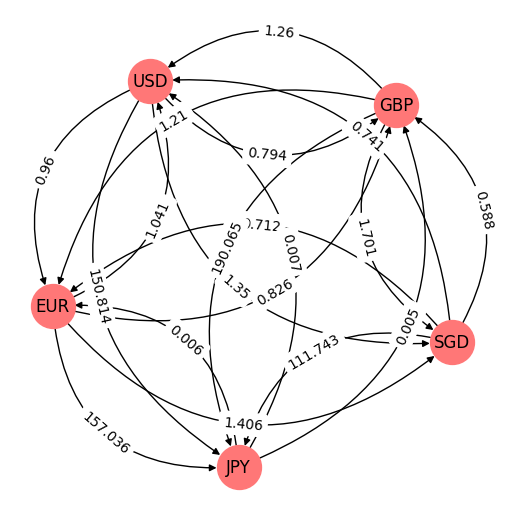

In [29]:
# Visualize the forex graph.

G = nx.DiGraph()

for currency1, rates in graph.items():
    for currency2, rate in rates.items():
        G.add_edge(currency1, currency2, weight=round(rate, 3))

pos = nx.nx_pydot.graphviz_layout(G, prog="neato")
edge_labels = nx.get_edge_attributes(G, "weight")

plt.figure(figsize=(5, 5))
nx.draw(G, pos, with_labels=True, node_size=1000, node_color="#FF7777", connectionstyle="arc3,rad=0.5")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, connectionstyle="arc3,rad=0.5")

plt.savefig("graph.png", dpi=300)
plt.show()

In [67]:
# Simple functions to help perform arbitrage.

def graph_exchange_to_log(graph: dict[str, dict[str, float]]) -> dict[str, dict[str, float]]:
    log_graph = dict()
    for currency in graph:
        log_graph[currency] = {c: -math.log(w) for c, w in graph[currency].items()}
    return log_graph

def bellman_ford(graph: dict[str, dict[str, float]]) -> bool:
    # Create a new graph in which each weight is the negative logarithm of the exchange rate.
    graph = graph_exchange_to_log(graph)

    # Add a sentinel source node with a weight 0 edge to each node.
    graph["\0"] = {c: 0 for c in graph}

    # Initialize the Bellman-Ford data structures.
    distance = {c: float("inf") for c in graph}
    distance["\0"] = 0
    predecessor = {c: None for c in graph}

    # Relax the edges V - 1 times.
    for _ in range(len(graph) - 1):
        for c1 in graph:
            for c2 in graph[c1]:
                weight = graph[c1][c2]
                if distance[c1] + weight < distance[c2]:
                    distance[c2] = distance[c1] + weight
                    predecessor[c2] = c1

    # Try to relax edges one more time. If possible, then there is a negative cycle.
    skips = 0
    for c1 in graph:
        for c2 in graph[c1]:
            weight = graph[c1][c2]
            if distance[c1] + weight < distance[c2]:
                if skips > 0:
                    skips -= 1
                    continue
                predecessor[c2] = c1
                visited = {c: False for c in graph}
                visited[c2] = True
                while not visited[c1]:
                    visited[c1] = True
                    c1 = predecessor[c1]
                negative_cycle = [c1]
                c2 = predecessor[c1]
                while c1 != c2:
                    negative_cycle = [c2] + negative_cycle
                    c2 = predecessor[c2]
                return negative_cycle

    return False

bellman_ford(graph)

['GBP', 'JPY']

In [60]:
graph["USD"]["JPY"] * graph["JPY"]["USD"]

1.0002286108